# Imports

In [22]:
%matplotlib inline
# %matplotlib widget
#% matplotlib qt
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import sklearn.neighbors._unsupervised
from draw_utils import draw_3d_clusters, draw_spiral_clusters
from matplotlib.ticker import LogFormatterExponent
plt.rcParams['figure.figsize'] = [15, 10]
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preview clusters for 2d and 3d manifolds

In [23]:
with open('./saved/ckpt_scurve.pickle', 'rb') as f:
    x = pickle.load(f)
X = x['X']
x.keys()

dict_keys(['knn', 'X', 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2])

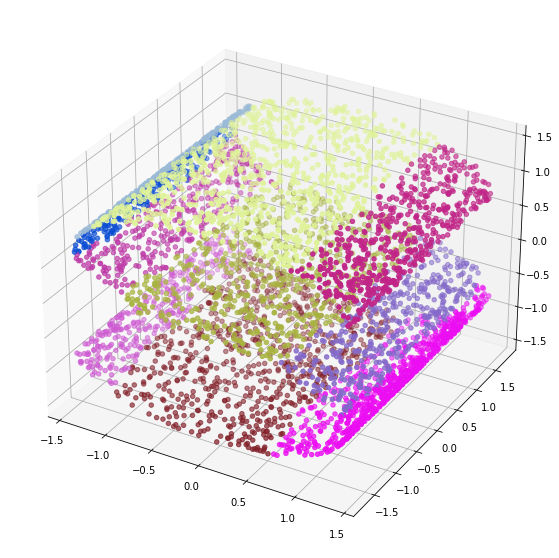

In [24]:
k = 10
C = x[k]['C']
if X[0].shape[0] == 2:
    draw_spiral_clusters(C, X, k=x['knn'])
elif X[0].shape[0] == 3:
    draw_3d_clusters(C, X, draw_planes=False)

# Compute error plot

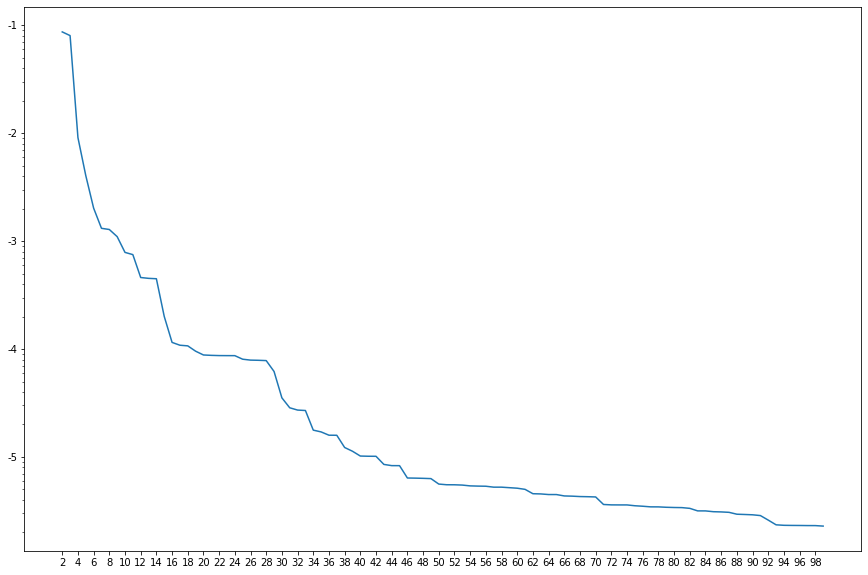

In [25]:
errors = {}
for it in x.keys():
    if it == 'knn' or it == 'X':
        continue
    
    e = []
    C = x[it]['C']
    for Ci in C:
        F = Ci.F
        P = np.dot(F, F.T)
        samples = np.array(X[Ci.indices]).T
        mean_pos = np.mean(samples, axis=1, keepdims=True)
        s = samples - mean_pos

        proj = np.dot(P, s)
        e.append((s - proj)**2)
    errors[it] = np.mean(np.concatenate(e, axis=1), axis=(0, 1))

plt.semilogy(list(errors.keys()), list(errors.values()))
ax = plt.gca()
plt.xticks(list(errors.keys())[1::2])
ax.yaxis.set_major_formatter(LogFormatterExponent())
plt.show()

# Preview BSDS reconstruction

In [365]:
with open('./saved/ckpt_bsds_64.pickle', 'rb') as f:
    x = pickle.load(f)
X = x['X']
x.keys()

dict_keys(['knn', 'X', 295, 290, 285, 280, 275, 270, 265, 260, 255, 250, 245, 240, 235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175, 170, 165, 160, 155, 150, 145, 140, 135, 130, 125, 120, 115, 110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5])

In [371]:
k = 10  # Number of clusters in checkpoint to use for reconstruction
proj = []
samples = []

C = x[k]['C']
for Ci in C:
    F = Ci.F
    P = np.dot(F, F.T)
    samp = np.array(X[Ci.indices]).T
    mean_pos = np.mean(samp, axis=1, keepdims=True)
    s = samp - mean_pos

    samples.extend(samp.T)
    proj.extend((np.dot(P, s) + mean_pos).T)

proj = np.concatenate(proj, axis=0).reshape((-1, 8, 8))
samples = np.concatenate(samples, axis=0).reshape((-1, 8, 8))
proj.shape, samples.shape

((5000, 8, 8), (5000, 8, 8))

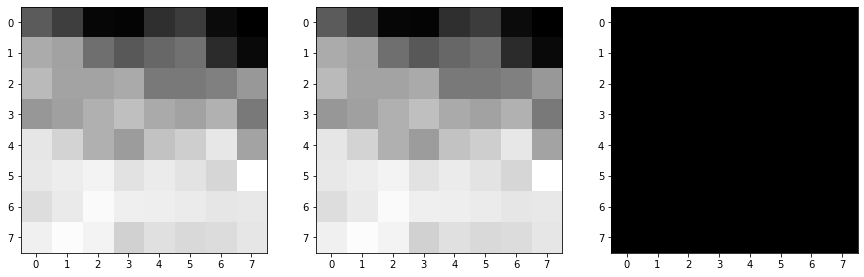

In [372]:
ith = 10
s = samples[ith]
p = proj[ith]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(s, cmap='gray')
ax2.imshow(p, cmap='gray')
ax3.imshow(np.clip(np.abs(p - s) * 255, 0, 255).astype(np.uint8), cmap='gray')

# Preview VIDTIMIT reconstruction

In [205]:
subject = 0
with open('./saved/ckpt_vidtimit_%s.pickle' % subject, 'rb') as f:
    x = pickle.load(f)
X = x['X']
x.keys()

dict_keys(['knn', 'X', 98, 96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2])

In [206]:
k = 14 # Number of clusters in checkpoint to use for reconstruction
proj = []
samples = []

C = x[k]['C']
for Ci in C:
    F = Ci.F
    P = np.dot(F, F.T)
    samp = np.array(X[Ci.indices]).T
    mean_pos = np.mean(samp, axis=1, keepdims=True)
    s = samp - mean_pos
    
    samples.extend(samp.T)
    proj.extend((np.dot(P, s) + mean_pos).T)
    
proj = np.concatenate(proj, axis=0).reshape((-1, 26, 26))
samples = np.concatenate(samples, axis=0).reshape((-1, 26, 26))
proj.shape, samples.shape

((742, 26, 26), (742, 26, 26))

In [178]:
from datasets_util import load_vidtimit
X_og = load_vidtimit('../data/vidtimit/', subject=subject, skip_pickle=False)
mean = np.mean(X_og, axis=0).reshape((26, 26))
std = np.std(X_og, axis=0).reshape((26, 26))
mean.shape, std.shape

((26, 26), (26, 26))

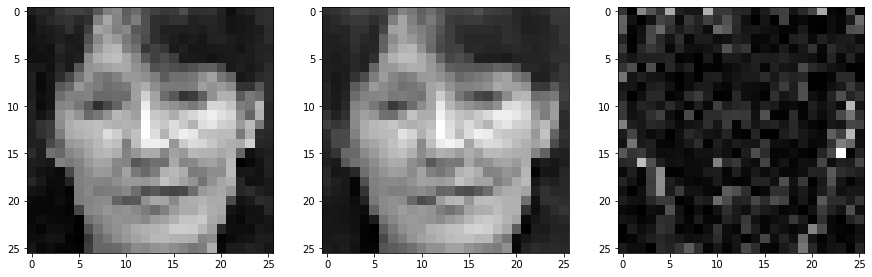

In [210]:
ith = 50
s = samples[ith]
p = proj[ith]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(s * std + mean, cmap='gray')
ax2.imshow(p * std + mean, cmap='gray')
ax3.imshow(np.abs(p - s), cmap='gray')

# Clusters preview

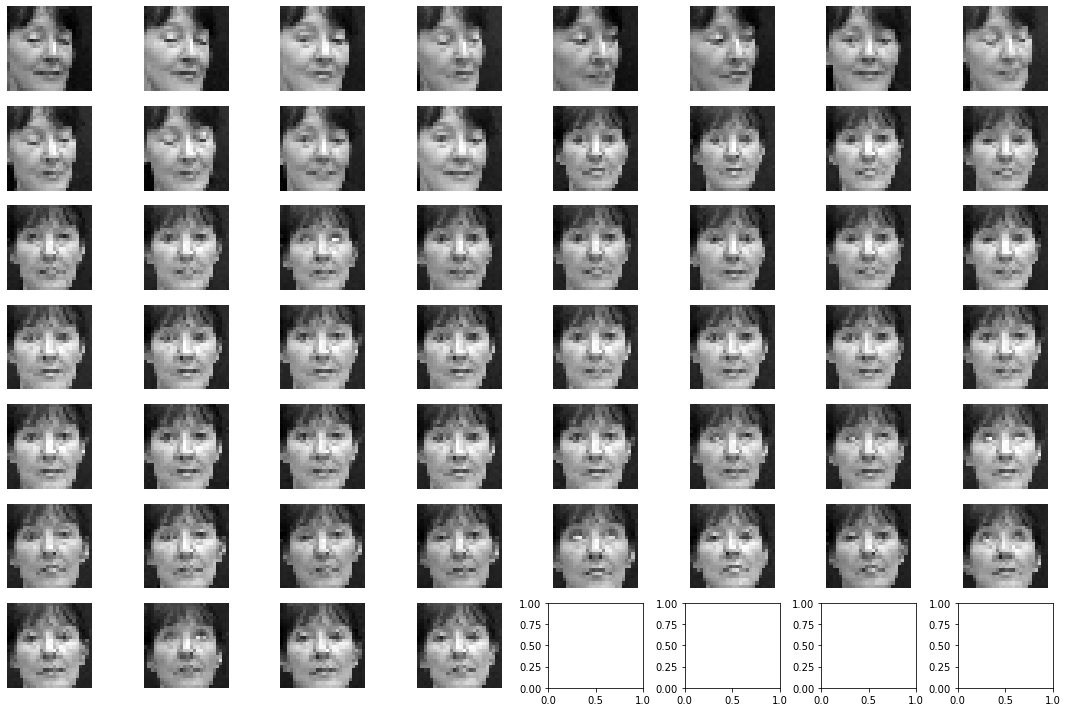

In [213]:
ith = 2
Ci = C[ith]
fig, axs = plt.subplots(nrows=int(np.sqrt(len(Ci.indices))), ncols=int(np.sqrt(len(Ci.indices)) + 1))
for i, ax in enumerate(axs.flat):
    if len(Ci) <= i:
        break
    ax.axis('off')
    s = X[Ci.indices[i]]
    ax.imshow((s.reshape((26, 26)) * std + mean), cmap='gray')
fig.tight_layout()

# MNIST

In [299]:
digit = 6
with open('./saved/ckpt_mnist_%s.pickle' % digit, 'rb') as f:
    x = pickle.load(f)
X = x['X']
x.keys()

dict_keys(['knn', 'X', 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5])

In [300]:
from mnist import MNIST
mndata = MNIST('../data/MNIST/')
images, labels = mndata.load_training()
images = np.array(images)
images = images / 255
labels = np.array(labels)
images.shape, labels.shape

((60000, 784), (60000,))

## GSI in original space

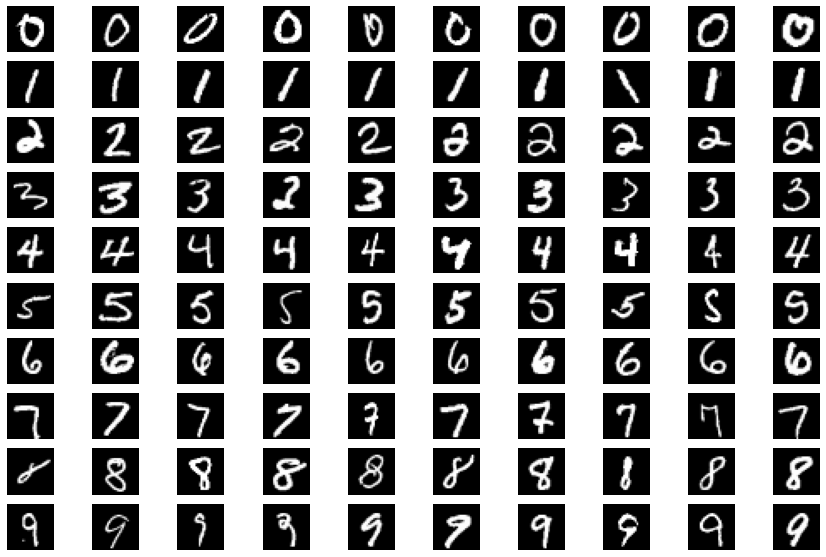

In [301]:
# Create balanced subset
s = 2000
X = np.zeros((s * 10, 784))
Y = np.zeros((s * 10))
for i in range(10):
    v = images[labels == i]
    X[s * i:s * (i + 1)] = v[np.random.choice(v.shape[0], size=s, replace=False)]
    Y[s * i:s * (i + 1)] = i
fig, axs = plt.subplots(ncols=10, nrows=10)
for ith, ax in enumerate(axs.flat):
    ax.imshow(X[s * (ith // 10) + ith % 10].reshape((28, 28)), cmap='gray')
    ax.axis('off')

In [302]:
# Compute GSI
knn = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(X)
n_idx = knn.kneighbors(X, return_distance=False)[:, 1:].squeeze(1)
GSI = np.sum(Y == Y[n_idx]) / X.shape[0]
GSI

0.9604

# Reconstruction MNIST

In [303]:
k = 10 # Number of clusters in checkpoint to use for reconstruction
proj = []
samples = []

C = x[k]['C']
for Ci in C:
    F = Ci.F
    P = np.dot(F, F.T)
    samp = np.array(x['X'][Ci.indices]).T
    mean_pos = np.mean(samp, axis=1, keepdims=True)
    s = samp - mean_pos
    
    samples.extend(samp.T)
    proj.extend((np.dot(P, s) + mean_pos).T)
    
proj = np.concatenate(proj, axis=0).reshape((-1, 28, 28))
samples = np.concatenate(samples, axis=0).reshape((-1, 28, 28))
proj.shape, samples.shape

((2000, 28, 28), (2000, 28, 28))

(2000, 28, 28) (2000, 28, 28)


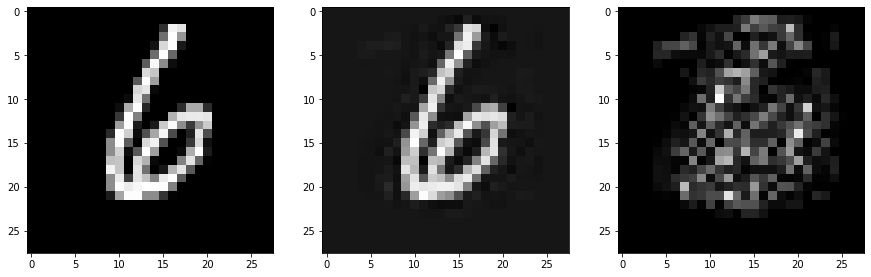

In [304]:
ith = 10
print(samples.shape, proj.shape)
s = samples[ith]
p = proj[ith]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(s * 255, cmap='gray')
ax2.imshow(p * 255, cmap='gray')
ax3.imshow(np.abs(p - s), cmap='gray')

# Clusters preview

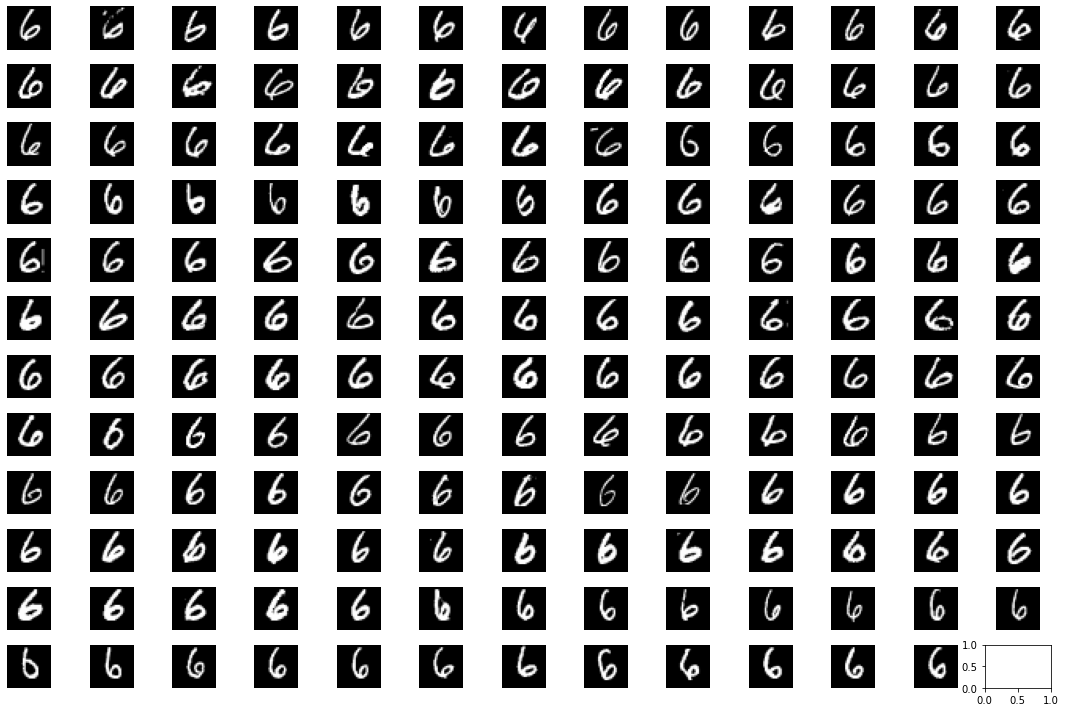

In [305]:
ith = 0
Ci = C[ith]
fig, axs = plt.subplots(nrows=int(np.sqrt(len(Ci.indices))), ncols=int(np.sqrt(len(Ci.indices)) + 1))
for i, ax in enumerate(axs.flat):
    if len(Ci) <= i:
        break
    ax.axis('off')
    s = x['X'][Ci.indices[i]]
    ax.imshow(s.reshape((28, 28)), cmap='gray')
fig.tight_layout()

# GSI on computed flats

In [306]:
C_digits = []
Xs = []
k
= 10  # Num clusters of ckpt to compute gsi

for i in range(10):
    with open('./saved/ckpt_mnist_%s.pickle' % i, 'rb') as f:
        p = pickle.load(f)
        C_digits.append(p[k]['C'])
        Xs.append(p['X'])

SyntaxError: invalid syntax (<ipython-input-306-1aec7fea1e4e>, line 4)

In [ ]:
# Compute distance matrix
d = np.zeros((X.shape[0], 10, k))  # n_samples x n_digits x flats
for C_idx, C in enumerate(C_digits):
    for Ci_idx, Ci in enumerate(C):
        F = Ci.F
        P = np.dot(F, F.T)
        samp = np.array(Xs[C_idx][Ci.indices]).T
        mean_pos = np.mean(samp, axis=1, keepdims=False)
        s = X - mean_pos

        proj = np.dot(s, P)
        d[:, C_idx, Ci_idx] = np.mean((s - proj) ** 2, axis=1)
np.save('./saved/dist_matrix_mnist.npy', d)
np.save('./saved/dist_matrix_mnist_X.npy', X)
np.save('./saved/dist_matrix_mnist_target.npy', Y)

In [48]:
# if d is precomputed
d_og = np.load('./saved/dist_matrix_mnist.npy')
X = np.load('./saved/dist_matrix_mnist_X.npy')
Y = np.load('./saved/dist_matrix_mnist_target.npy')

In [ ]:
# Compute GSI fitting the D matrix
d_flat = d.reshape((-1, 10 * k))
knn = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(d_flat)
n_idx = knn.kneighbors(d_flat, return_distance=False)[:, 1:].squeeze(1)
GSI = np.sum(Y == Y[n_idx]) / X.shape[0]
GSI

## Results GSI
Original space - Flat space (100dim)
- 0.96055 - 0.94095
- 0.95845 - 0.9397
- 0.9608 - 94245

# Classification accuracy

Accuracy of 96.63000000000001% on 10000 samples


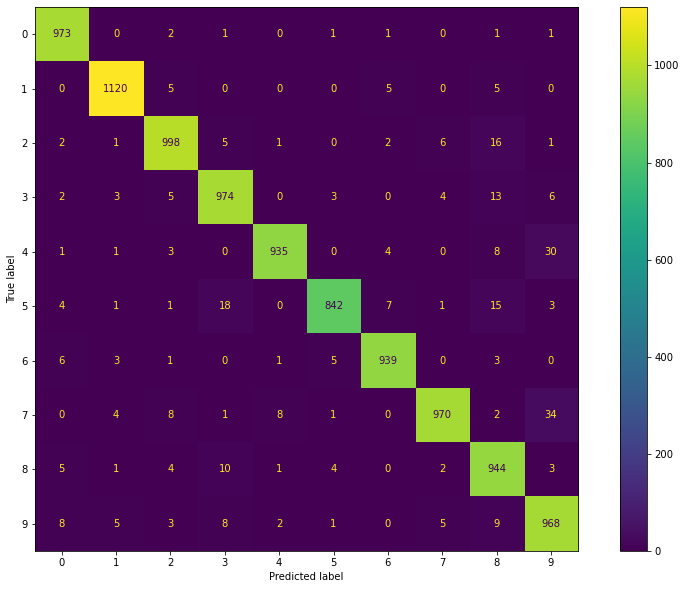

In [360]:
# Compute distance on test data
images_val, labels_val = mndata.load_testing()
labels_val = np.array(labels_val)
images_val = np.array(images_val) / 255
k = 10

d = np.zeros((images_val.shape[0], 10, k))  # n_samples x n_digits x flats
for C_idx, C in enumerate(C_digits):
    for Ci_idx, Ci in enumerate(C):
        F = Ci.F
        P = np.dot(F, F.T)
        samp = np.array(Xs[C_idx][Ci.indices]).T
        mean_pos = np.mean(samp, axis=1, keepdims=False)
        s = images_val - mean_pos

        proj = np.dot(s, P)
        d[:, C_idx, Ci_idx] = np.mean((s - proj) ** 2, axis=1)
d_flat = d.reshape((-1, 10 * k))       
acc = accuracy_score(labels_val, np.argmin(d_flat, axis=1) // 10)
conf_matrix = confusion_matrix(labels_val, np.argmin(d_flat, axis=1) // 10)
print('Accuracy of %s%% on %s samples' % (acc*100, labels_val.shape[0]))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(range(10))).plot()

0: 2.965263%
1: 7.226998%
2: 4.499794%
3: 6.601831%
4: 37.853447%
5: 5.650781%
6: 4.044427%
7: 8.657196%
8: 5.702434%
9: 16.797829%


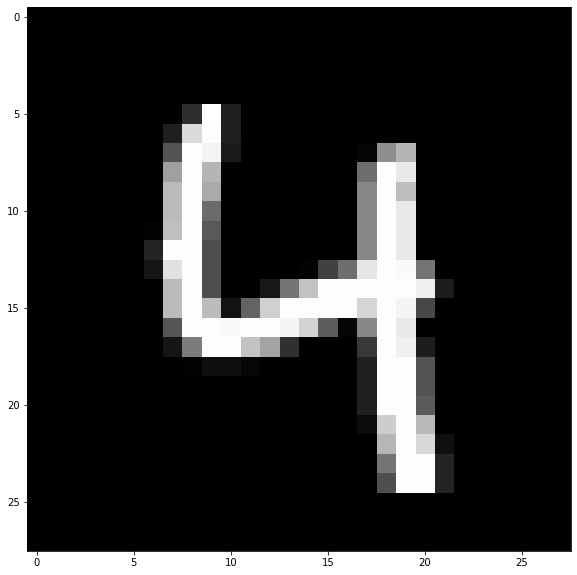

In [353]:
# Plain classification
ith = 9601
pred = 1 / np.min(d, axis=2)
pred = pred / np.sum(pred, axis=1, keepdims=True)
print('\n'.join('%s: %f%%' % (a, b * 100) for (a, b) in zip(list(range(10)), pred[ith])))
plt.imshow(X[ith].reshape((28, 28)), 'gray')